# Federated inference and learning for the **Roots & Culture (RC)** model

## 1. Introduction

**Federated variational inference and learning** (also known as **collaborative inference and learning**) is a novel probabilistic inference scheme that allows for inverting a hierarchical generative model using multiple decentralized nodes (i.e. edge devices or servers) holding local data samples. This is done without having to pull the local data to a central node or exchanging the data samples between nodes.

The central challenge that federated inference and learning tries to solve is to allow multiple actors to build a common, robust generative model without sharing data. This way, various issues related to data control can be addressed, such as data privacy, data security, data access rights, and access to heterogeneous data. Moreover, this approach saves the bandwidth required to collect and store potentially large amounts of data on centralized servers.

Here, we showcase a federated variational inference and learning scheme for a generic plant growth model. What makes the federated approach especially appropriate for this is that, besides obvious data privacy and security concerns, we can expect that different users might have access to different data as a source for inferring relevant model parameters. In a generative model, this translates into a user-specific likelihood function. Importantly, for federated learning to make sense, we must assume that besides data likelihoods, the rest of the generative model is shared across users. In other words, users will use the data to perform inference over a shared set of model parameters and latent states describing plant growth and the dynamics of other relevant variables.

To further elaborate on how this works, consider a scenario where the federated plant growth model is being used by multiple users. These users will have access to different measurments in different settings. For example, one user's dataset may contain information on the growth of plants in a greenhouse while another user's dataset may describe the growth of plants in an outdoor garden. The federated approach allows these users to contribute their data to a common model without sharing it. This is achieved user specific estimation of model parameters given local data samples. The estimated parameters are then passed between nodes which aggregate them to obtain a shared set of parameters that describe the model. This shared set of parameters is then used by all users to perform inference over the entire dataset. By doing this, the federated approach enables the creation of a more robust model that can capture the heterogeneity of the data, while still preserving the privacy and security of the data samples.



## 2. Background information
**Roots & Culture (RC)** is an indoor hemp farm in Virginia, USA where high CBD hemp flowers are grown, harvested, then processed into extract which is infused into skincare products. Since 2018, they have been growing indoors because it offers control over all aspects of the environment, ensuring plants experience only the most favourable conditions during development. The result is an extremely clean, high-value extract which is perfect for dermatological applications.

The **RC** generative model maps a sequence of actions (interventions, such as, planting, irrigating and harvesting) during a growth season, and a set of model parameters, into a time series of latent states (plant count, plant size, soil organic matter, growth rate, soil water status, and evapotranspiration rate) and observables (e.g. total yield). Therefore, the model represents a simple digital twin of the Roots & Culture indoor hemp farm.

***For more info on the RC model please read [RC Model](https://github.com/gaia-os/gaia-hub/blob/main/notebooks/LAB-roots-and-culture.ipynb).***

***For an introduction to the base level modeling framework visit [Get Started notebook](https://github.com/gaia-os/gaia-hub/blob/main/notebooks/get_started.ipynb).***

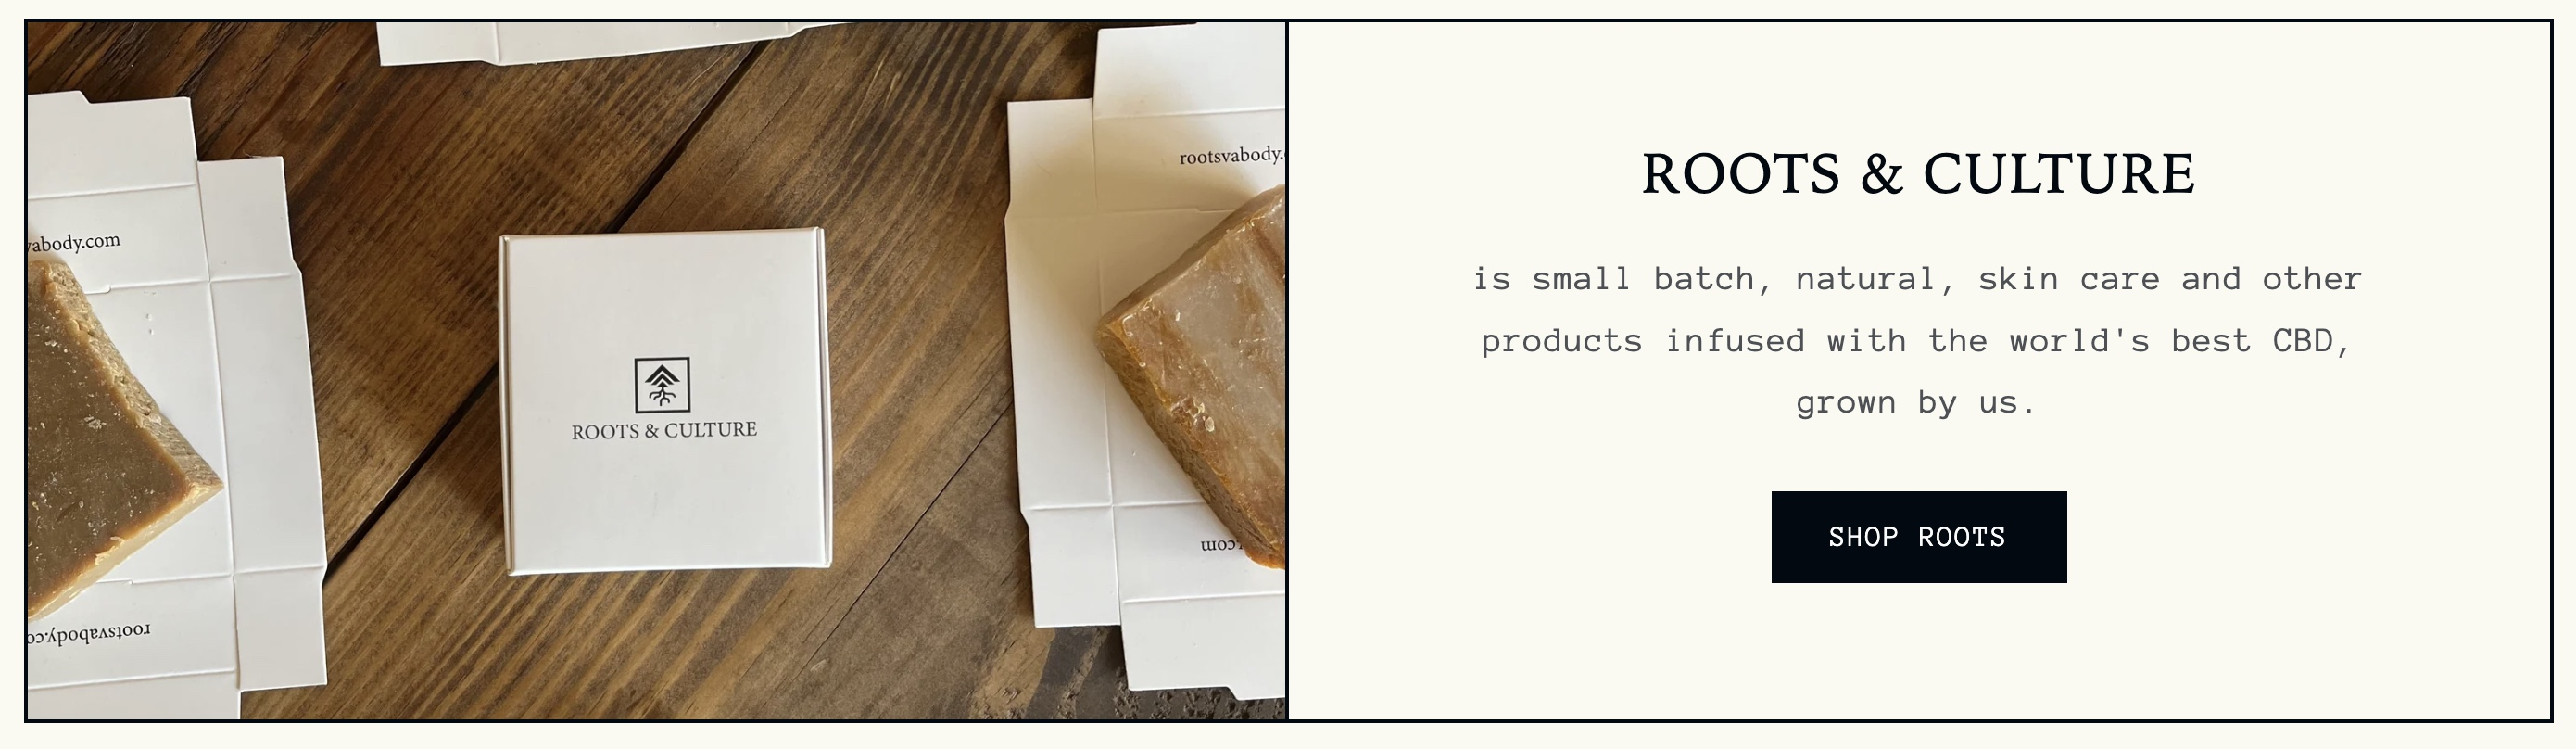

## 3. A summary of the process 
We will start by importing the existing dataset from the **Roots & Culture (RC)** indoor hemp farm. This dataset we will use to invert the model and constrain the range of viable model parameters in the form of posterior estimate.

Using the posterior distribution we will simulate a novel set of $N=50$ farms, each which a unique set of parameters and measurments sampled from the generative model. 

Finally, we will define a hirerarchical generative model and a corresponding approximate posterior which we will use in a federated setting for estimation of the posterior over global model parameters, that is, hyper-parameters. The knowledge about the global posterior is shared between clients and over time improved sufficiently so that each client improves their local estimates of the model parameter.

We will start by defining the programming environment and introducing basic components required for model inversion.

**Set up the environment**

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
# Import required packages
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.tree_util as jtu
import optax

from jax import random as jr
from jax import nn
from numpyro import set_platform, handlers
from numpyro.optim import optax_to_numpyro
from numpyro.infer import TraceGraph_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal


# # Retrieve the fangorn directory (option 2)
# import digital_gaia.fangorn as fangorn
# fangorn_dir = dirname(dirname(dirname(abspath(fangorn.__file__))))

# Tell numpyro whether to use cpu or gpu
use_gpu = False
if use_gpu is True:
    set_platform('gpu')
else:
    set_platform('cpu')
    
# Import required classes from the fangorn module
from digital_gaia.fangorn.agents.agent_factory import AgentFactory
from digital_gaia.fangorn.assessment.data_loader import DataLoader
from digital_gaia.fangorn.kernels.impl.svi_kernel import SVIKernel

# Import required classes from fedbmr package 
from fedbmr.feds import InfFed

**Load the configuration file and agent(s)**

In [3]:
# Load the configuration file corresponding to the Roots & Culture model
project_file = '../data/projects/Roots-and-Culture/roots-indoor1.json' 
reports_dir = '../data/reports/Roots-and-Culture/'
verbose = True
data_loader = DataLoader(project_file, reports_dir=reports_dir, verbose=verbose)

[INFO] Reports' columns: report_id, datetime, location, reporter, t, lot, pl.roots_agent.SoilOrganicMatter.Continuous, v1.measurement.base.agriculture.Yield.HempYield.Continuous
[INFO] Reports' rows:
[INFO] 
[INFO]  index :  0
[INFO]  report_id :  3496cd6c-ab30-44af-ac80-de336152526a
[INFO]  datetime :  2019-06-24
[INFO]  location :  POINT (37.7085650094281 -78.78430384696541)
[INFO]  reporter :  rob@element.6.com
[INFO]  t :  25
[INFO]  lot :  0
[INFO]  pl.roots_agent.SoilOrganicMatter.Continuous :  7.1
[INFO]  v1.measurement.base.agriculture.Yield.HempYield.Continuous :  nan
[INFO] 
[INFO]  index :  1
[INFO]  report_id :  2696cd6c-ab30-44af-ac80-de336152526a
[INFO]  datetime :  2019-10-14
[INFO]  location :  POINT (37.70860398672815 -78.78439022651558)
[INFO]  reporter :  rob@element.6.com
[INFO]  t :  41
[INFO]  lot :  0
[INFO]  pl.roots_agent.SoilOrganicMatter.Continuous :  7.4
[INFO]  v1.measurement.base.agriculture.Yield.HempYield.Continuous :  323.92
[INFO] 


In [4]:
# Load the agents agent(s) compatible with the loaded data
agents = AgentFactory.create(data_loader, verbose=True)

# Get ordinary differential equations (ODE) and stochastic differential equations (SDE) agents
ode_agent = next(filter(lambda a: a.name == "Roots-and-Culture.roots-indoor1.Deterministic", agents))

[INFO] Agents found:
[INFO] 	- <class 'digital_gaia.fangorn.agents.impl.get_started_agent.GetStartedAgent'>
[INFO] 	- <class 'digital_gaia.fangorn.agents.impl.roots_agent.RootsAndCultureAgent'>
[INFO] 
[INFO] Project interventions:
[INFO] 	- v1.management.base.agriculture.Irrigation.IrrigateCrops.Yes
[INFO] 	- v1.management.base.agriculture.Planting.PlantingSeeds.HempSeeds
[INFO] 	- v1.management.base.agriculture.Harvest.HarvestCrops.Hemp
[INFO] 	- v1.management.base.agriculture.Pruning.PruneCrops.Yes
[INFO] 	- v1.management.base.agriculture.Fertilizer.FertilizeSoil.Yes
[INFO] 
[INFO] Agents satisfying interventions:
[INFO] 	- <class 'digital_gaia.fangorn.agents.impl.roots_agent.RootsAndCultureAgent'>
[INFO] 
[INFO] Project species:
[INFO] 	- v1.genetics.base.plant.Plant.PlantSpecies.Hemp
[INFO] 
[INFO] Agents satisfying interventions and species:
[INFO] 	- <class 'digital_gaia.fangorn.agents.impl.roots_agent.RootsAndCultureAgent'>
[INFO] 


In [5]:
ode_agent.obs_to_site

{'v1.measurement.base.agriculture.Yield.HempYield.Continuous': 'obs_yield',
 'pl.roots_agent.SoilOrganicMatter.Continuous': 'obs_soil_organic_matter'}

In [6]:
ode_agent.get_hyperparameters()

{'growth_function_mean': Array(34.5, dtype=float32),
 'growth_function_std': Array(2.1666667, dtype=float32),
 'max_growth_rate': 0.5,
 'evaporation_rate': 0.05,
 'soil_type': <SoilType.SiltLoams: 8>,
 'lot_area': Array([104], dtype=int32),
 'max_root_depth': 0.5,
 'max_evapotranspiration_rate': 1,
 'yield_potential': 0.578,
 'n_seeds': 84,
 'time_delta': 1,
 'weekly_irrigation': 1500,
 'obs_soil_organic_matter_var.a': 0.5,
 'obs_soil_organic_matter_var.b': 1.0,
 'obs_yield_var.a': 0.5,
 'obs_yield_var.b': 1.0,
 'soil_organic_matter.mu': 0.055,
 'soil_organic_matter.scale': 100.0,
 'saturation_point': Array([9966.32], dtype=float32, weak_type=True),
 'wilting_point': Array([6500.], dtype=float32, weak_type=True)}

In [7]:
data_loader.reports

,report_id,datetime,location,reporter,t,lot,pl.roots_agent.SoilOrganicMatter.Continuous,v1.measurement.base.agriculture.Yield.HempYield.Continuous
0,3496cd6c-ab30-44af-ac80-de336152526a,2019-06-24,POINT (37.70857 -78.78430),rob@element.6.com,25,0,7.1,NaN
1,2696cd6c-ab30-44af-ac80-de336152526a,2019-10-14,POINT (37.70860 -78.78439),rob@element.6.com,41,0,7.4,323.92


In [8]:
# Format data
project_mask = []
project_data = []
for lot in data_loader.reports.lot.unique():
    df = data_loader.reports.loc[data_loader.reports.lot == lot, ['t', ] + data_loader.obs_names]
    df.set_index('t', inplace=True)
    df = df.reindex(range(52))
    project_mask.append({ode_agent.obs_to_site[key]: ~df[key].isna().values for key in data_loader.obs_names})
    project_data.append({ode_agent.obs_to_site[key]: df[key].fillna(0.).values for key in data_loader.obs_names})

project_mask = jtu.tree_map( lambda *args: jnp.stack(list(args), axis=-1), project_mask)[0]
project_data = jtu.tree_map( lambda *args: jnp.stack(list(args), axis=-1), project_data)[0]

print(project_mask.keys(), project_mask['obs_yield'].shape)
print(project_data.keys(), project_data['obs_yield'].shape)

dict_keys(['obs_soil_organic_matter', 'obs_yield']) (52, 1)
dict_keys(['obs_soil_organic_matter', 'obs_yield']) (52, 1)


In [9]:
# Provide the data to the agent
cond_model, guide = ode_agent.condition_all(data=project_data)
print(cond_model)
print(guide)

# test model and guide
with handlers.seed(rng_seed=0):
    cond_model(mask=project_mask)
    guide(mask=project_mask)

In [10]:
# Create the SVI algorithm
svi_args = {
    "optimiser": optax_to_numpyro(optax.adabelief(1e-3)),
    "loss": TraceGraph_ELBO(num_particles=16),
    "num_steps": 10_000
}
svi_algorithm = ode_agent.inference_algorithm(SVIKernel, kernel_args=svi_args)

# Perform inference using SVI
inference_kwargs = {
    "stable_update": True, 
    "mask": project_mask
}
svi_samples = svi_algorithm.run_inference(inference_kwargs=inference_kwargs)
svi_samples.pop('obs_yield');

100%|██████████| 10000/10000 [00:02<00:00, 3617.43it/s, init loss: 27738.6211, avg. loss [9501-10000]: 11.8033]


In [11]:
svi_samples.keys()

dict_keys(['evapotranspiration_rate', 'growth_rate', 'obs_soil_organic_matter', 'obs_som_scale', 'obs_yield_std', 'plant_count', 'plant_size', 'soil_organic_matter', 'soil_water_status', 'wilting', '_auto_latent', '_obs_som_var', '_obs_yield_var', 'soil_organic_matter.t0'])

Text(0.5, 1.0, 'SOM$_{\\sigma}$')

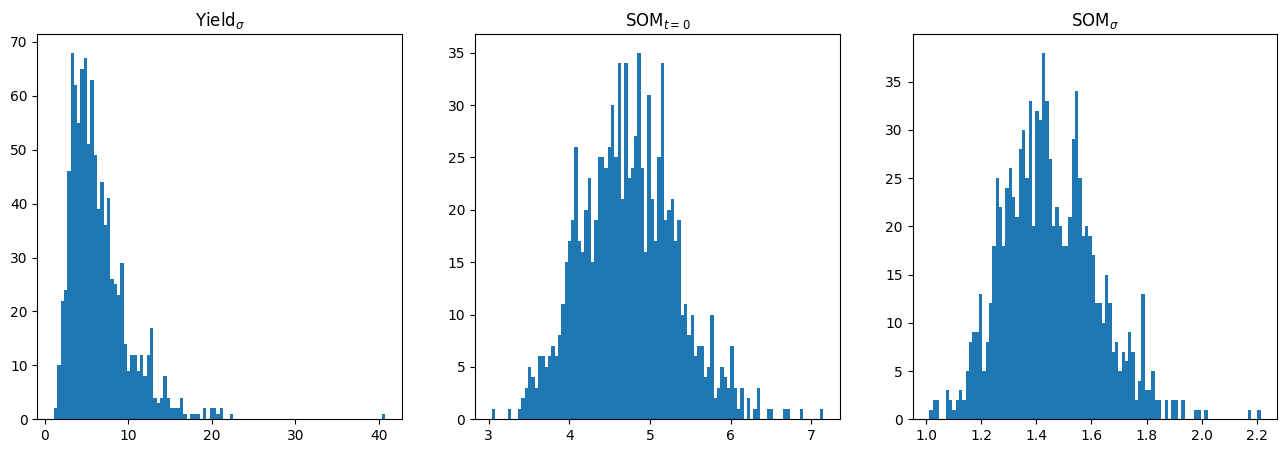

In [26]:
# Plot posterior estimate over model parameters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].hist(svi_samples['obs_yield_std'], bins=100);
axes[0].set_title(r'Yield$_{\sigma}$');
axes[1].hist(svi_samples['soil_organic_matter.t0'].squeeze() * 100, bins=100);
axes[1].set_title(r'SOM$_{t=0}$');
axes[2].hist(svi_samples['obs_som_scale'], bins=100);
axes[2].set_title(r'SOM$_{\sigma}$');

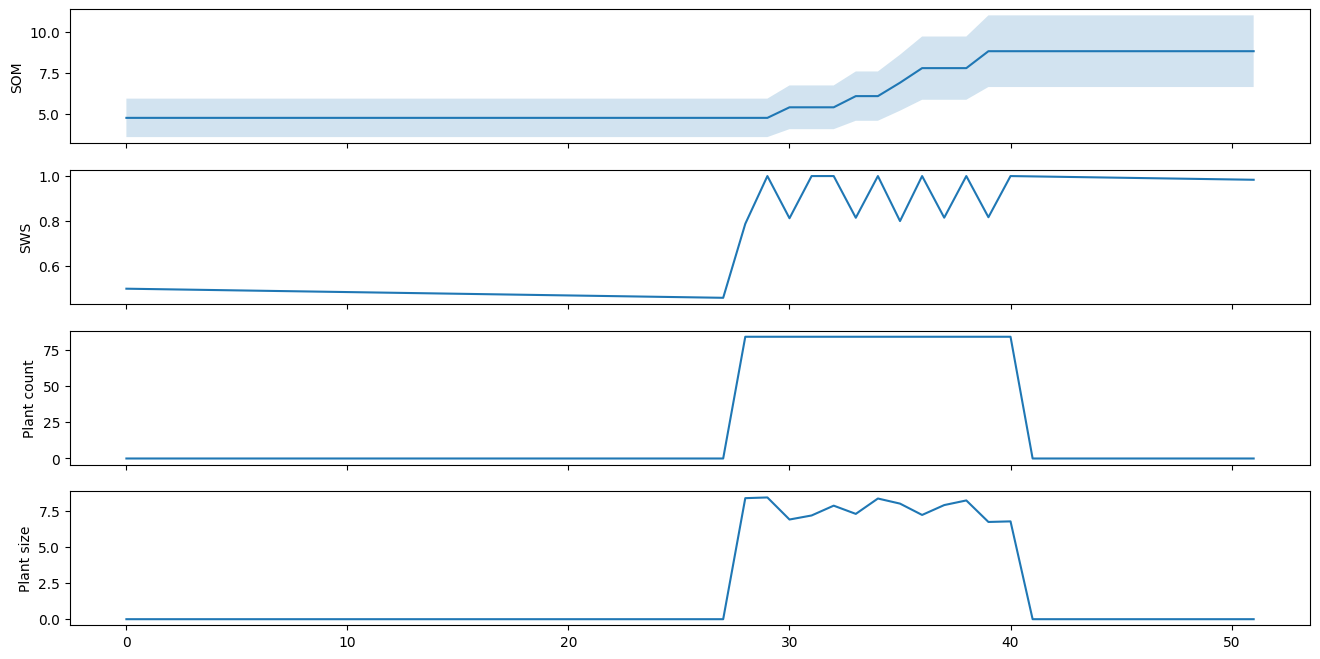

In [28]:
# Visualize posterior beliefs over latent states

fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

for ax, name, label in zip(axes, ["soil_organic_matter", "soil_water_status", "plant_count", "plant_size"], ['SOM', 'SWS', "Plant count", "Plant size"]):
    mu = svi_samples[name].mean(0).squeeze()
    std = svi_samples[name].std(0).squeeze()
    x = jnp.arange(len(mu))
    ax.plot(x, svi_samples[name].mean(0).squeeze())
    ax.fill_between(x, mu - 2 * std, y2=mu + 2 * std, alpha=0.2)
    ax.set_ylabel(label)

# Federated inference of model parameters



Here we will use a federated inference setup for inference and learning of global posterior over hyper-parameters. We will start by defining a hierarchical generative model for the Roots-and-Culture model in the following form 
```python
def hierarchical_model(data):
    hyperparams = sample('hyperparams', ...)
    local_cond_model = ode_agent.condition_model(data=data)
    with plate('num_clients', nc):
        local_cond_model(hyperparams)
```

In [30]:
from fedbmr.feds import GenerativeModel, GlobalPrior

from numpyro import sample, deterministic, handlers
import numpyro.distributions as dist

# specify properties of the global prior (hyper-prior)
prior_specs = {
    "u_yield":  dist.Gamma,
    "u_som":  dist.Gamma,
    "u_som_t0":  dist.Gamma
}

default_param_vals = {
    "u_yield":  dict(concentration=.5, rate=1.),
    "u_som": dict(concentration=.5, rate=1.),
    "u_som_t0": dict(concentration=.5, rate=1.)
    
}

global_prior = GlobalPrior(prior_specs, default_param_vals)
global_prior();

In [35]:
# define hyper prior distribution
def hyperprior(prior, **kwargs):
    output_dict = {}
    for name, p in prior.items():
        output_dict[name] = sample("global." + name, p.dist)

    output_dict["obs_yield_var.b"] = deterministic("obs_yield_var.b", 1 / output_dict["u_yield"])
    output_dict["obs_soil_organic_matter_var.b"] = deterministic("obs_soil_organic_matter_var.b", 1 / output_dict["u_som"])
    output_dict["soil_organic_matter.scale"] = deterministic("soil_organic_matter.scale", 1 / output_dict["u_som_t0"])

    return output_dict | kwargs

with handlers.seed(rng_seed=0):
    print(hyperprior(global_prior()))

{'u_som': Array(0.5482233, dtype=float32), 'u_som_t0': Array(0.12155401, dtype=float32), 'u_yield': Array(0.00785721, dtype=float32), 'obs_yield_var.b': Array(127.27159, dtype=float32), 'obs_soil_organic_matter_var.b': Array(1.8240741, dtype=float32), 'soil_organic_matter.scale': Array(8.226795, dtype=float32)}


In [36]:
# link RC model with the hyper-prior and form hierarchical generative model
def local_model(input_dict):
    # Load the agents agent(s) compatible with the loaded data
    data_loader = input_dict.pop('data_loader')
    agents = AgentFactory.create(data_loader, verbose=False)

    # Get ordinary differential equations (ODE) and stochastic differential equations (SDE) agents
    name = input_dict.pop('agent_name')
    ode_agent = next(filter(lambda a: a.name == name, agents))

    data = input_dict.pop('data', None)
    ode_agent.update_hyperparameters(input_dict)

    if data is not None:
        model = ode_agent.condition_model(data=data)
    else:
        model = ode_agent.model
    
    model()

hierarchical_model = GenerativeModel(global_prior(), hyperprior, local_model)

In [42]:
model_kwargs = {
    'data_loader': data_loader,
    'agent_name': "Roots-and-Culture.roots-indoor1.Deterministic"
}

smpl = Predictive(hierarchical_model, num_samples=1)(jr.PRNGKey(0), **model_kwargs)
print('u_yield: {};'.format(smpl['global.u_yield'][0]), 'scale: {}'.format(smpl['obs_yield_std'][0]))
print('u_som: {};'.format(smpl['global.u_som'][0]), 'scale: {}'.format(smpl["obs_som_scale"][0]))
print('u_som_t0: {};'.format(smpl['global.u_som_t0'][0]), 't0: {}'.format(smpl['soil_organic_matter.t0'][0]))

u_yield: 0.007857212796807289; scale: 29.551206588745117
u_som: 0.5482233166694641; scale: 13.235007286071777
u_som_t0: 0.12155400961637497; t0: [0.05742554]


## Define a hierarchical posterior

For the inference scheme to work under federated inference we need to assume the same functional form of the posterior as for the prior. Furthermore, the approximate posterior will follow the same structure as the hierarchical generative model

```python
def hierarchical_posterior(*args, **kwargs):
    hyperparams = GlobalPosterior()
    LocalPosterior(hyperparams)
```

In [43]:
from fedbmr.feds import Posterior
from numpyro import param, prng_key

def _gamma(name, shape=()):

    a = param(
        name + '.concentration', 
        lambda rng_key: dist.Uniform(.5, 10)(rng_key=rng_key, sample_shape=shape),
        constraint=dist.constraints.positive
    )
    
    b = param(name + '.rate', jnp.ones(shape), constraint=dist.constraints.positive)

    return dist.Gamma(a, b)

def global_posterior(*args, **kwargs):

    u_yield = sample('global.u_yield', _gamma('global.u_yield'))
    u_som = sample('global.u_som', _gamma('global.u_som'))
    u_som_t0 = sample('global.u_som_t0', _gamma('global.u_som_t0'))


    output_dict = {}

    output_dict["obs_yield_var.b"] = 1 / u_yield
    output_dict["obs_soil_organic_matter_var.b"] = 1 / u_som
    output_dict["soil_organic_matter.scale"] = 1 / u_som_t0

    return output_dict | kwargs

def local_posterior(input_dict):

    # Load the agents agent(s) compatible with the loaded data
    data_loader = input_dict.pop('data_loader')
    key = prng_key()
    agents = AgentFactory.create(data_loader, key=key, verbose=False)

    # Get ordinary differential equations (ODE) and stochastic differential equations (SDE) agents
    name = input_dict.pop('agent_name')
    ode_agent = next(filter(lambda a: a.name == name, agents))

    data = input_dict.pop('data', None)
    ode_agent.update_hyperparameters(input_dict)

    _, guide = ode_agent.condition_all(data)
    guide()

posterior = Posterior(global_posterior, local_posterior)
model_kwargs['data'] = project_data

with handlers.seed(rng_seed=0):
    posterior(**model_kwargs)

## Generate samples for Federated inference example

In [64]:
rng_key = jr.PRNGKey(777)

# sample data
num_clients = 20
pred = Predictive(ode_agent.model, posterior_samples=svi_samples, return_sites=['obs_yield'])
sample_data = pred(rng_key)

# create clients and pass local data
federation = {}
for i in range(num_clients):
    local_data = {'obs_yield': sample_data['obs_yield'][i]}

    n_measurements = len(local_data['obs_yield'])
    arg_max = jnp.argmax(local_data['obs_yield'])
    local_mask = {
        'obs_yield': jnp.expand_dims(nn.one_hot(arg_max, n_measurements, dtype=bool), -1)
    }

    global_prior = GlobalPrior(prior_specs, default_param_vals)
    gm = GenerativeModel(global_prior(), hyperprior, local_model)
    post = Posterior(global_posterior, local_posterior)
    inf_fed = InfFed(global_prior, gm, post)

    federation[i] = {
        'model_kwargs': {
            'data_loader': data_loader,
            'agent_name': "Roots-and-Culture.roots-indoor1.Deterministic",
            'data': local_data, 
            'mask': local_mask
        }, 
        'client': inf_fed
    }

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

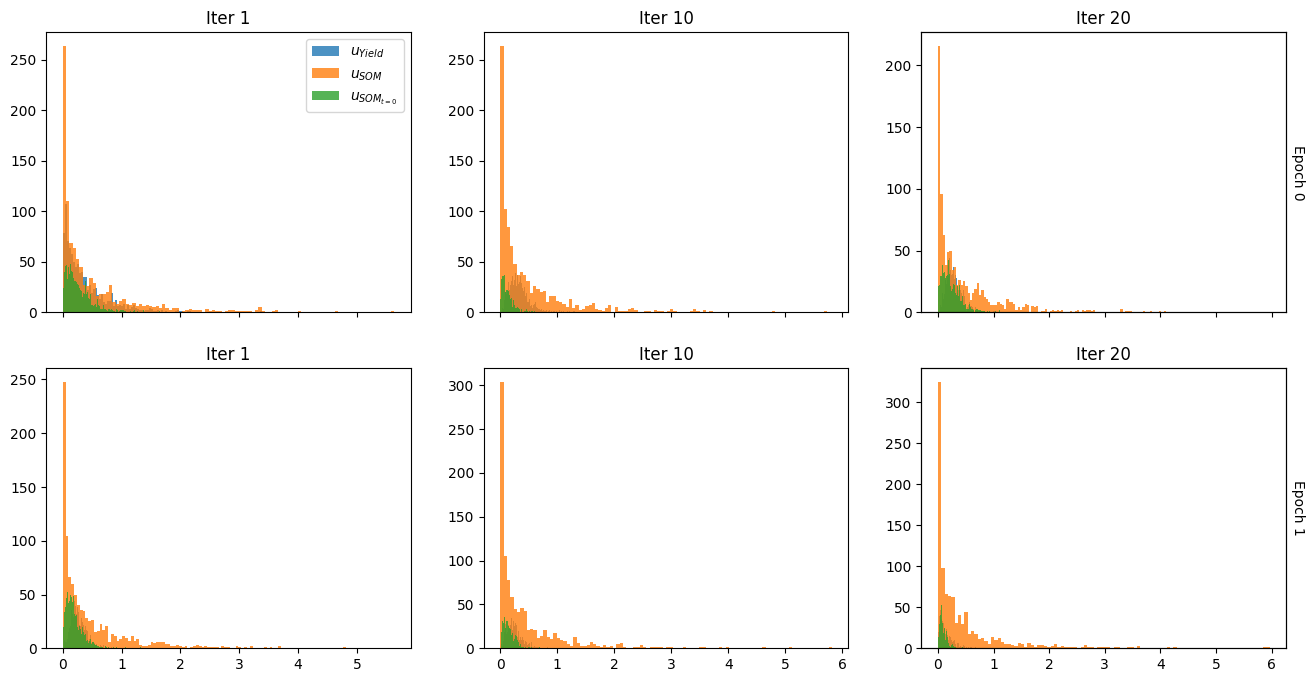

In [65]:
# sequential algorithm
from tqdm.auto import tqdm


fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='col')

num_epochs = 2
gp = federation[0]['client'].global_prior()
for e in range(num_epochs):
    posteriors = []
    rng_key, key = jr.split(rng_key)
    # random ordering of clients
    order = [x.item() for x in jr.choice(key, num_clients, shape=(num_clients,), replace=False)]
    for n in tqdm(order):
        rng_key, _rng_key = jr.split(rng_key)
        federation[n]['client'].recieve_prior(gp)
        model_kwargs = federation[n]['model_kwargs']
        federation[n]['client'].inference(
            _rng_key, 
            model_kwargs, 
            num_steps=10_000,
            opt_kwargs={'learning_rate': 1e-3}
        )
        gp = federation[n]['client'].send_posterior()
        posteriors.append( gp )

    for i, idx in enumerate([0, 9, 19]): 
        gm = GenerativeModel(posteriors[idx], hyperprior, local_model)
        rng_key, _rng_key = jr.split(rng_key)
        fed_smpl = Predictive(gm, num_samples=1000)(_rng_key, **federation[idx]['model_kwargs'])

        axes[e, i].hist(fed_smpl['global.u_yield'], bins=100, alpha=0.8, label=r'$u_{Yield}$');
        axes[e, i].hist(fed_smpl['global.u_som'], bins=100, alpha=0.8, label=r'$u_{SOM}$');
        axes[e, i].hist(fed_smpl['global.u_som_t0'], bins=100, alpha=0.8, label=r'$u_{SOM_{t=0}}$');


        axes[e, i].set_title(f"Iter {idx + 1}")

    axes[0, 0].legend()
    twin = axes[e, -1].twinx()
    twin.set_ylabel(f'Epoch {e}', rotation=-90, labelpad=10)
    twin.set_yticks([])